### Tensor data and label genearation: 

In [1]:
import tensorflow as tf
import os

image_dir_train = "../Data/AutismDataset_Images/train/"
image_dir_valid = "../Data/AutismDataset_Images/valid/"
image_dir_test = "../Data/AutismDataset_Images/test/"
image_size = (None, None)  # Set the desired image size

# Define a generator function to yield image and label pairs
def image_label_generator(image_dir):
    # Iterate over the images in the directory
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(image_dir, filename)
            
            # Load the image and extract the label from the filename or any other method you use to get the label
            image = tf.io.read_file(image_path)
            image = tf.image.decode_image(image, channels=3)
            if filename.startswith("A"):
                label = 1
            elif filename.startswith("N"):
                label = 0 
            
            yield image, label

# Create the datasets using from_generator()
train_ds = tf.data.Dataset.from_generator(
    lambda: image_label_generator(image_dir_train),
    output_signature=(
        tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
        tf.TensorSpec(shape=(), dtype=tf.int64)
    )
)

validation_ds = tf.data.Dataset.from_generator(
    lambda: image_label_generator(image_dir_valid),
    output_signature=(
        tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
        tf.TensorSpec(shape=(), dtype=tf.int64)
    )
)

test_ds = tf.data.Dataset.from_generator(
    lambda: image_label_generator(image_dir_test),
    output_signature=(
        tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
        tf.TensorSpec(shape=(), dtype=tf.int64)
    )
)

### Data presentation: 

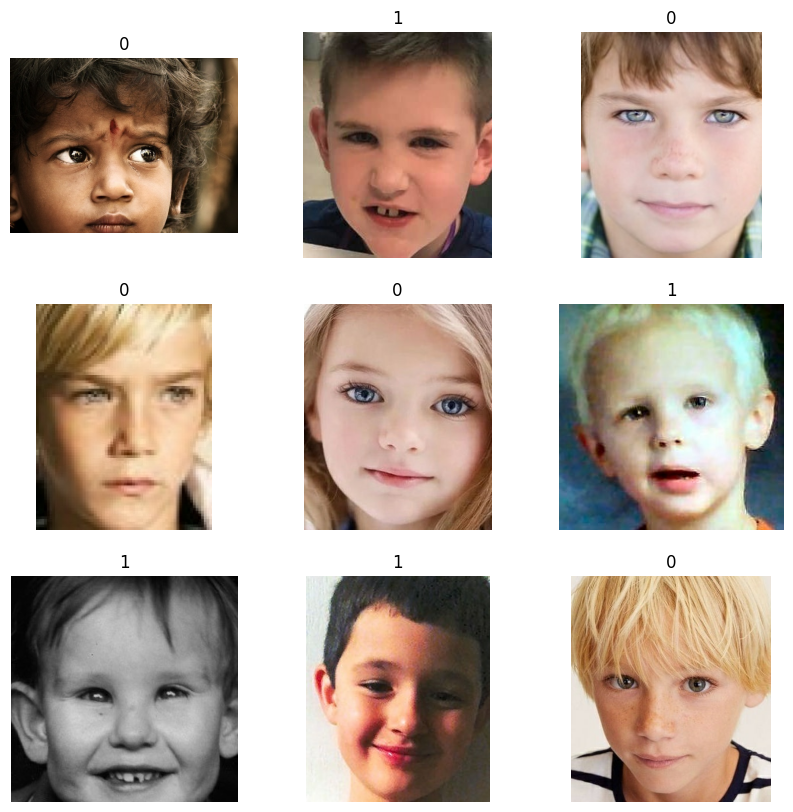

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

### Data Unification: 

In [3]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [4]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

### Image Augmentation: 

2023-11-28 11:01:27.428819: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


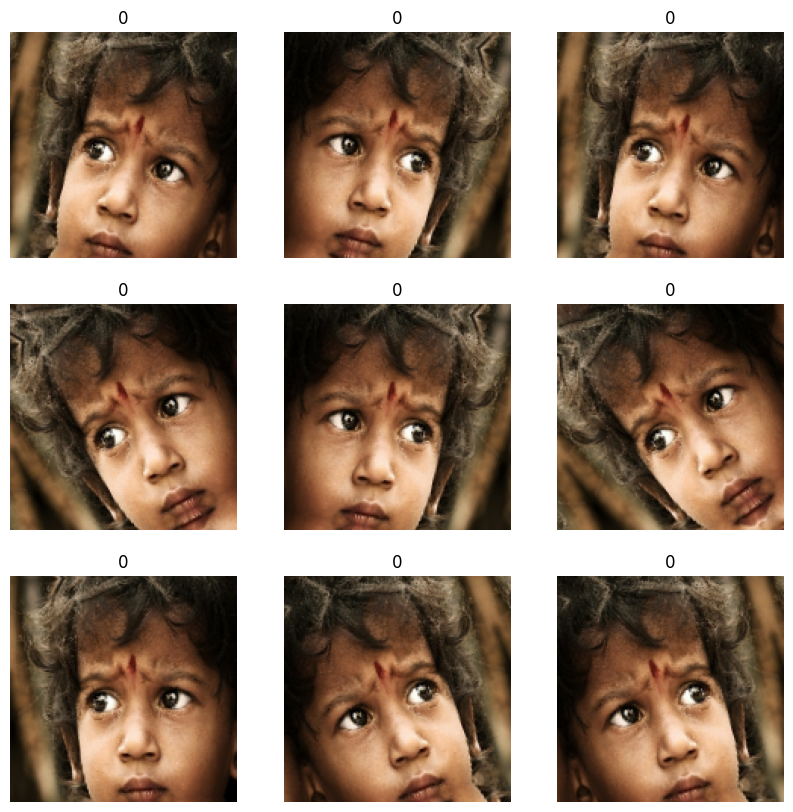

In [6]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

### Model Importation and summarization: 

In [7]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [8]:
base_model = keras.applications.ConvNeXtXLarge(
    weights="imagenet",
    input_shape=(150, 150, 3),
    include_top=False
)
# base_model = keras.applications.Xception(
#     weights="imagenet",  # Load weights pre-trained on ImageNet.
#     input_shape=(150, 150, 3),
#     include_top=False,
# )  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 convnext_xlarge (Functiona  (None, 4, 4, 2048)        348147968 
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0     

### Model compilation: 20 epoch

In [9]:
model.compile(
    optimizer=keras.optimizers.legacy.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20


2023-11-28 11:01:41.118127: I external/local_xla/xla/service/service.cc:168] XLA service 0x2e7609ca0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-11-28 11:01:41.118368: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1701156701.246783       1 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-11-28 11:01:41.247395: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


80/80 [==============================] - 2140s 27s/step - loss: 0.6014 - binary_accuracy: 0.6421
Epoch 2/20
80/80 [==============================] - 1236s 15s/step - loss: 0.4951 - binary_accuracy: 0.7457
Epoch 3/20
80/80 [==============================] - 1222s 15s/step - loss: 0.4624 - binary_accuracy: 0.7642
Epoch 4/20
80/80 [==============================] - 1228s 15s/step - loss: 0.4426 - binary_accuracy: 0.7783
Epoch 5/20
80/80 [==============================] - 1160s 15s/step - loss: 0.4307 - binary_accuracy: 0.7846
Epoch 6/20
48/80 [=================>............] - ETA: 7:54 - loss: 0.4320 - binary_accuracy: 0.7832

### Model compilation: 10 epoch

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.legacy.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 convnext_xlarge (Functiona  (None, 4, 4, 2048)        348147968 
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0     

### Label defining: 

In [ ]:
label_test = []
for i,(image,label) in enumerate(test_ds):
    label_test.extend(np.array(label))
label_train = []
for i,(image,label) in enumerate(train_ds):
    label_train.extend(np.array(label))    

### Applying label threshold: 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
predict1 = predict
thresh = 0
preds = np.zeros(300)
for i in range(300):
    if predict1[i]>thresh:
        preds[i] = 1
    elif predict1[i]<thresh:
        preds[i] = 0

print(classification_report(label_test, preds))
sns.heatmap(confusion_matrix(np.array(label_test), preds),annot=True, fmt='d')

NameError: name 'predict' is not defined

### Model Load: 

In [1]:
from tensorflow.keras.models import load_model
model = load_model('VGG16.h5')

In [13]:
import tensorflow as tf
import os
def image_label_generator(image_dir):
    # Iterate over the images in the directory
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(image_dir, filename)
            
            # Load the image and extract the label from the filename or any other method you use to get the label
            image = tf.io.read_file(image_path)
            image = tf.image.decode_image(image, channels=3)
            if filename.startswith("A"):
                label = 1
            elif filename.startswith("N"):
                label = 0 
            else: 
                label = 0
            
            yield image, label
image_dir_test = "../../../profile pictures"
test_ds = tf.data.Dataset.from_generator(
    lambda: image_label_generator(image_dir_test),
    output_signature=(
        tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
        tf.TensorSpec(shape=(), dtype=tf.int64)
    )
)
size = (150, 150)
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))
batch_size = 32
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)
predict = model.predict(test_ds)

1/1 [==============================] - 1s 784ms/step


### Applyin SVM model on image prediction to improve performance: 

10/10 [==============================] - 12s 1s/step
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       150
           1       0.87      0.85      0.86       150

    accuracy                           0.86       300
   macro avg       0.86      0.86      0.86       300
weighted avg       0.86      0.86      0.86       300



<Axes: >

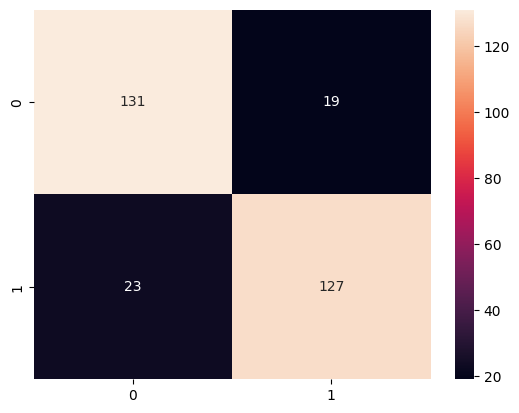

In [318]:

from lightgbm import LGBMClassifier
from sklearn.cluster import k_means
from sklearn.ensemble import RandomForestClassifier, RandomTreesEmbedding
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.tree import DecisionTreeClassifier

# X_train, X_test, y_train, y_test = train_test_split(predict, label_train, test_size=0.3,stratify=label_, random_state=42)
X_train = model.predict(train_ds)
X_test = model.predict(test_ds)

# sm = SMOTEENN()
# X_train1, label_train1 = sm.fit_resample(X_train, label_train)
model1 = SVC(kernel='rbf')
# model1 = RandomForestClassifier()
model1.fit(X_train, label_train)
pred_ = model1.predict(X_test)
print(classification_report(label_test, pred_))
sns.heatmap(confusion_matrix(label_test, pred_),annot=True, fmt='d')